# RGB classification with decision trees
### Подготовил: Степанюк Денис Борисович
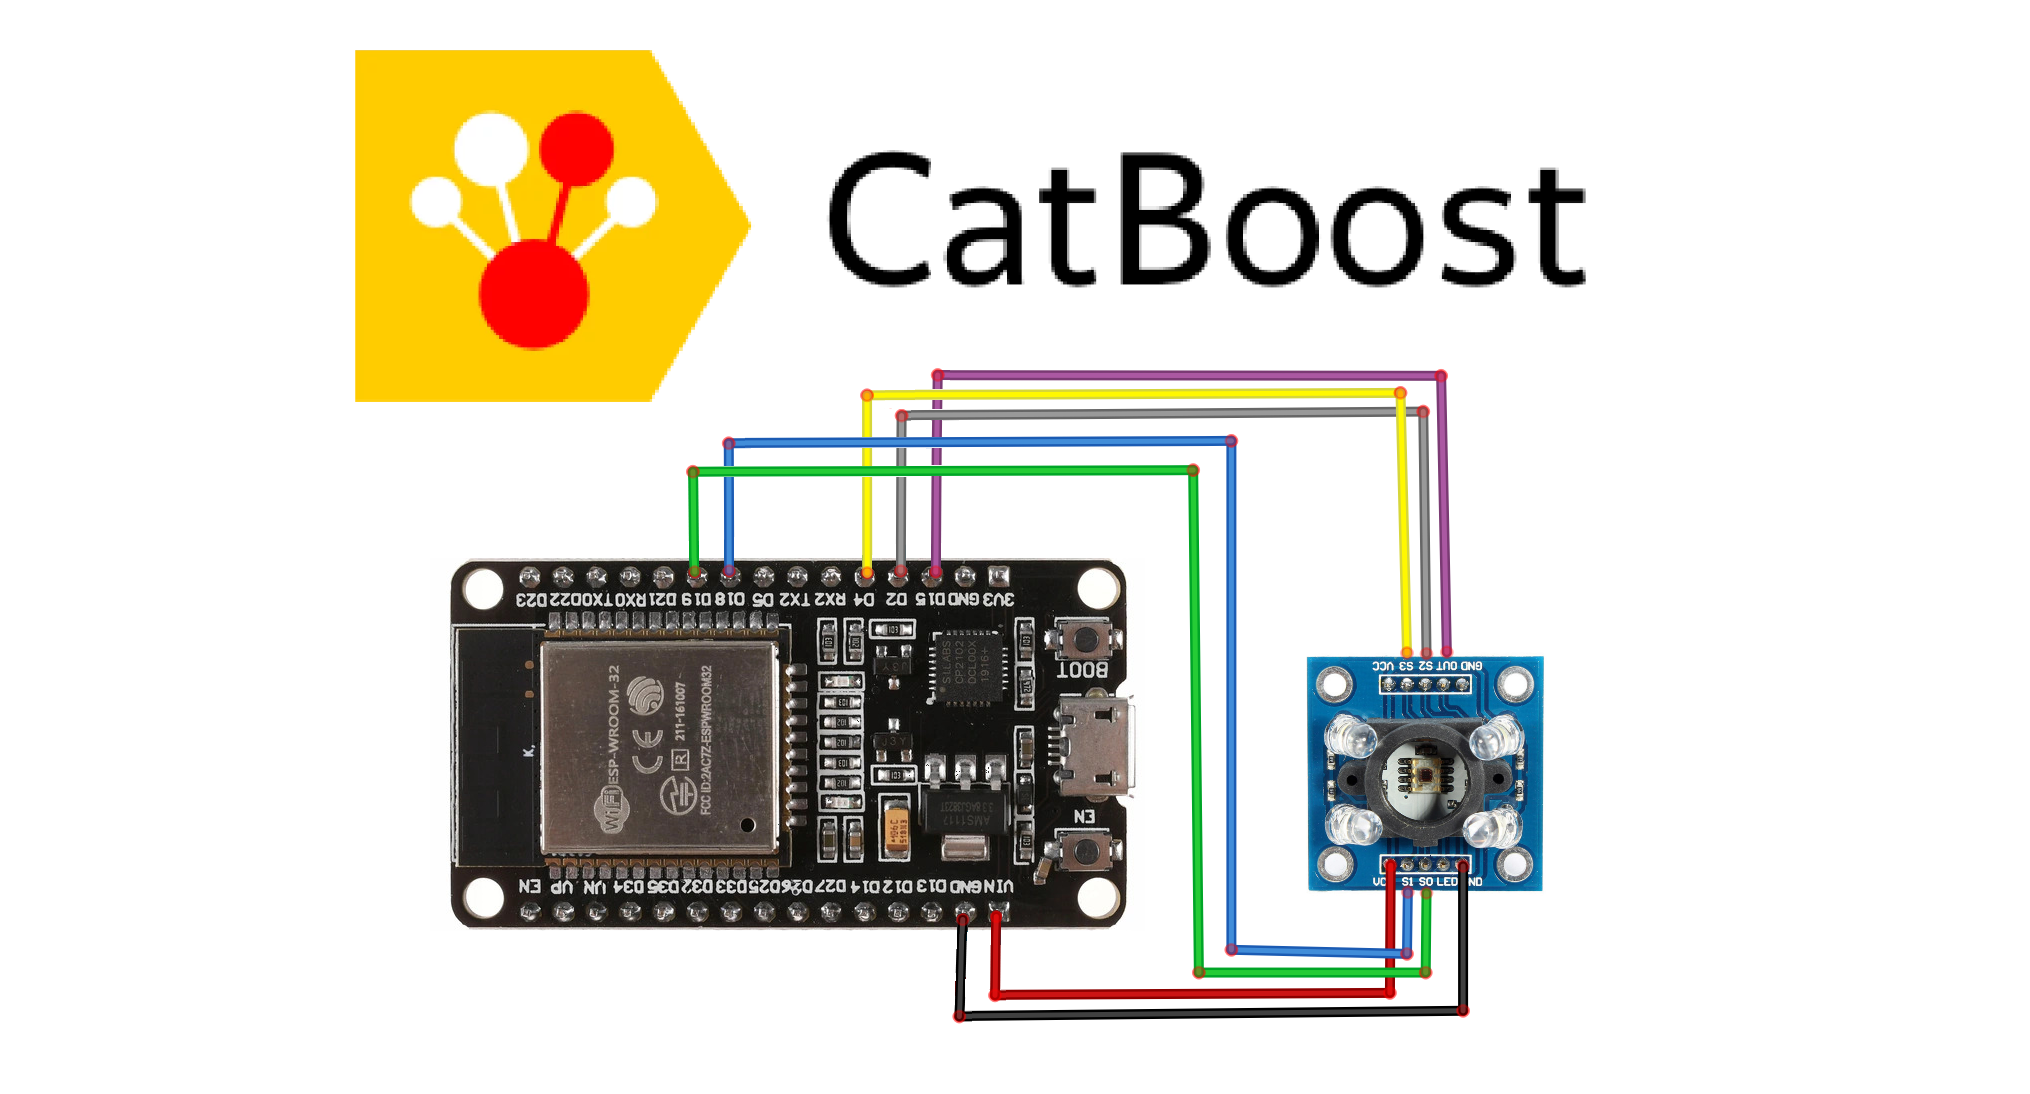

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Числовые признаки.
num_cols = [
    'RED',
    ' GREEN',
    ' BLUE',
    ' WHITE'
]

# Предсказываемый категориальный признак.
target_col = ' COLOR'

# Загрузим данные.
data = pd.read_csv('./DATASET_ESP32.txt')

# Посмотрим на 'n' случайных строчек
data.sample (n = 10)

RED   GREEN   BLUE   WHITE    COLOR   0 
51   15      25     14       6   Purple   52
57   12      24     14       5   Purple   58
35   19      17     21       6    Green   36
52   13      24     14       5   Purple   53
17    8      15     18       4   Orange   18
49   24      15     11       4     Blue   50
34   19      17     21       6    Green   35
73   54      57     47      16    Black   74
66    5       8      7       2    White   67
7     9      26     19       5      Red    8

## 3D график

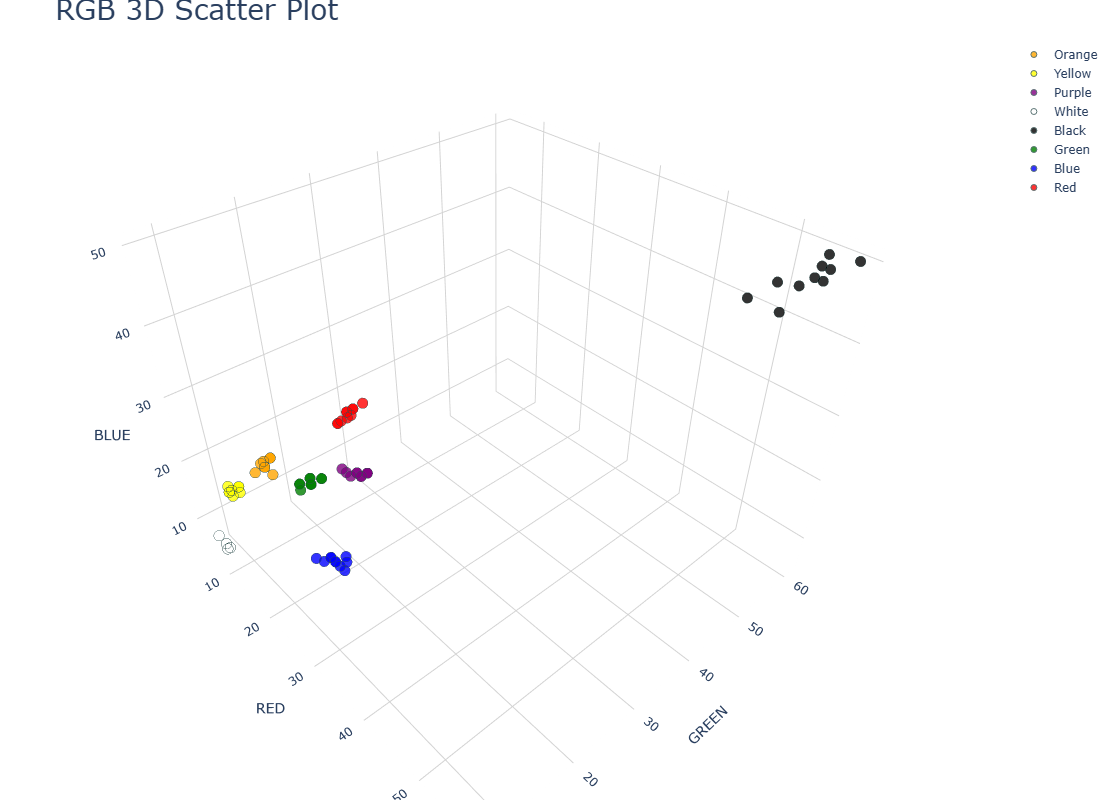

In [3]:
import plotly.graph_objects as go

colors = data[' COLOR'].str.strip()
fig = go.Figure()

color_map = {
    'Orange': 'orange',
    'Yellow': 'yellow',
    'Purple': 'purple',
    'White': 'white',
    'Black': 'black',
    'Green': 'green',
    'Blue': 'blue',
    'Red': 'red'
}

for color_name, plot_color in color_map.items():
    mask = colors == color_name
    fig.add_trace(go.Scatter3d(
        x=data.loc[mask, 'RED'],
        y=data.loc[mask, ' GREEN'],
        z=data.loc[mask, ' BLUE'],
        mode='markers',
        marker=dict(
            size=6,                # Сделать точки больше
            color=plot_color,
            opacity=0.8,            # Немного прозрачные
            line=dict(width=1, color='DarkSlateGrey')  # Обводка у точек
        ),
        name=color_name
    ))

fig.update_layout(
    scene=dict(
        xaxis_title='RED',
        yaxis_title='GREEN',
        zaxis_title='BLUE',
        xaxis=dict(backgroundcolor="white", gridcolor="lightgrey", showbackground=True),
        yaxis=dict(backgroundcolor="white", gridcolor="lightgrey", showbackground=True),
        zaxis=dict(backgroundcolor="white", gridcolor="lightgrey", showbackground=True),
    ),
    title=dict(text='RGB 3D Scatter Plot', font=dict(size=28)),
    width=1000,  # Больше ширина
    height=800,  # Больше высота
    margin=dict(l=0, r=0, b=0, t=40),  # Меньше отступы
    template='plotly_white'  # Светлая красивая тема
)

fig.show()

## Подготовка данных

In [4]:
# Признаки на которых будем обучать модель предсказывать цвет.
X_data = data[num_cols]
X_data.head(n=5)

RED   GREEN   BLUE   WHITE
0   10      28     21       6
1   10      28     21       5
2   10      26     20       5
3   11      27     21       6
4   11      29     22       6

In [5]:
from sklearn.preprocessing import LabelEncoder

# Получим текстовые метки цвета из датафрейма.
Y_data_text = data[target_col]

# Заменим текстовые метки цвета на числовые.
Y_data_idx = LabelEncoder().fit_transform(Y_data_text)

# Отобразим соответствие текстовых меток числовым.
colors = pd.DataFrame({'COLOR': Y_data_text.values, 'IDX': Y_data_idx}).drop_duplicates()
colors

COLOR  IDX
0       Red    5
10   Orange    3
20   Yellow    7
30    Green    2
40     Blue    1
50   Purple    4
60    White    6
70    Black    0

In [6]:
from sklearn.model_selection import train_test_split

# Разделим датасет на две части (тренировочную и тестовую).
X_train, X_test, Y_train, Y_test = train_test_split(X_data.values, Y_data_idx, train_size = 0.75)

## Дерево решений
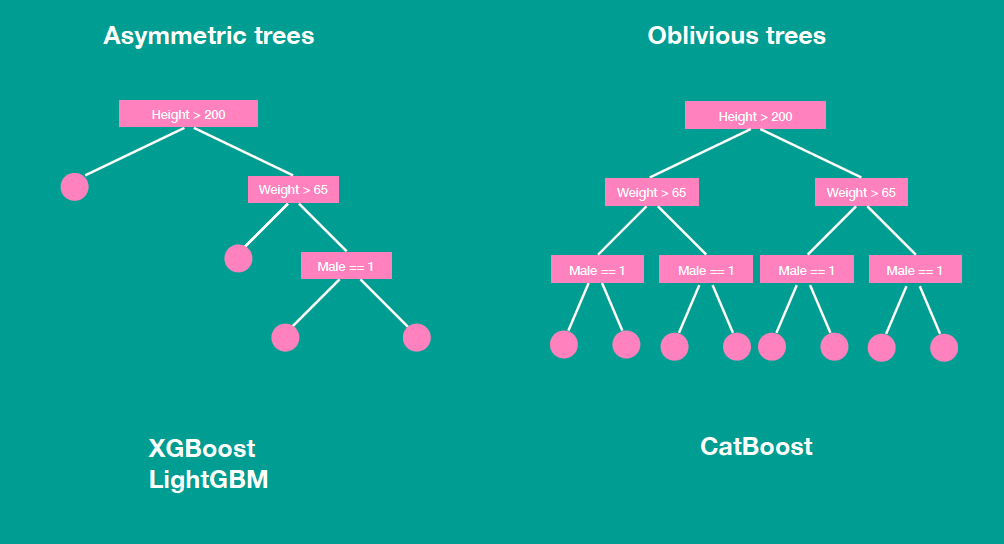

In [7]:
# CatBoost - высокопроизводительная библиотека с открытым исходным кодом для градиентного бустинга на деревьях решений.
#import catboost
from catboost import CatBoostClassifier, Pool

In [8]:
# Инициализируем модель градиентного бустинга на деревьях решений.
boosting_model = CatBoostClassifier(classes_count = 8, # Кол-во предсказываемых классов.
                                             num_trees=1, # Кол-во деревьев решений.
                                             loss_function='MultiClass') # Функция потерь для многоклассовой классификации.

# Оболочка, объединяющая признаки, метки и дополнительные метаданные, такие как категориальные признаки или базовые данные.
pool = Pool(X_train, Y_train, feature_names=num_cols)

# Обучим модель передав тренировочный датасет.
#boosting_model.fit(X_train, Y_train)
boosting_model.fit(pool)

# Предскажем классы для тренировочных данных.
Y_train_predicted = boosting_model.predict_proba(X_train)
# Предскажем классы для тестовых данных.
Y_test_predicted = boosting_model.predict_proba(X_test)

Learning rate set to 0.5
0:	learn: 1.4742440	total: 152ms	remaining: 0us


In [9]:
from sklearn.metrics import roc_auc_score

# Оценим качество обученой модели сравнив предсказания с правильными ответами.
print(roc_auc_score(Y_train, Y_train_predicted, multi_class='ovr', average='macro'))
print(roc_auc_score(Y_test, Y_test_predicted, multi_class='ovr', average='macro'))

0.9702987516903767
0.9691154970760234


## Визуализация дерева решений
#### Скачайте Graphviz для визуализации дерева решений: https://graphviz.org/download/

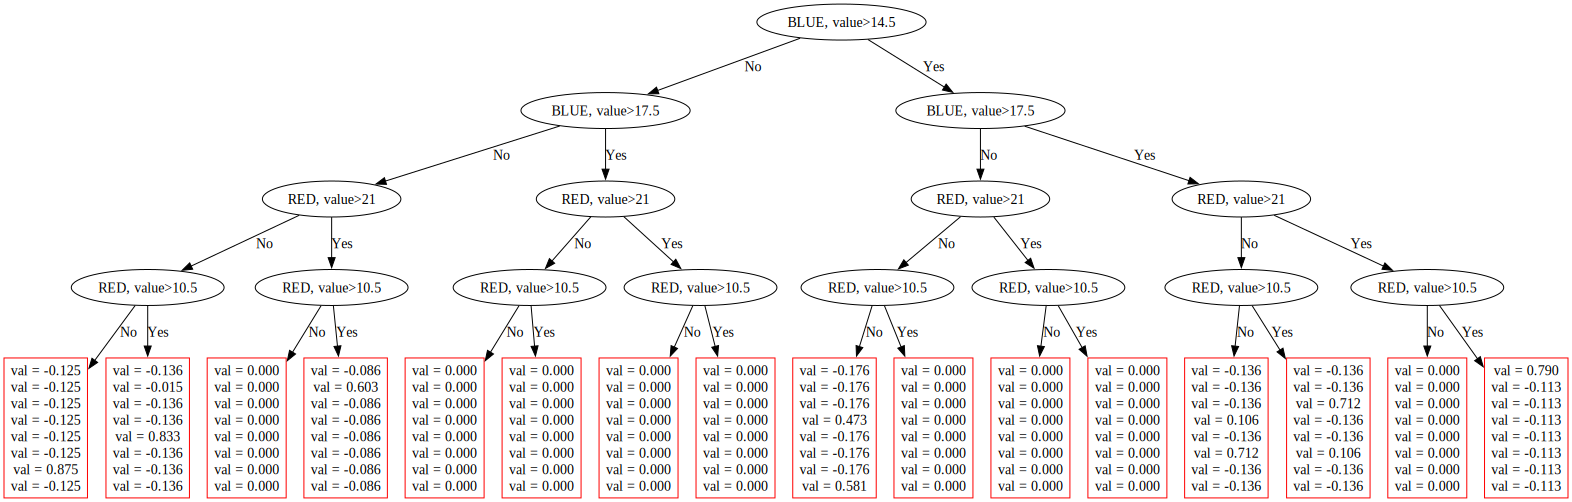

In [10]:
# Построим дерево решений.
boosting_model.plot_tree(tree_idx=0, pool=pool)

In [11]:
# Получим категории на выходе модели в правильной последовательности.
colors_indexed = colors.set_index('IDX')
idx_array = boosting_model.classes_
print(idx_array)
output_categories = colors_indexed.loc[idx_array]['COLOR'].tolist()
print(output_categories)
print(boosting_model.feature_names_)
print(num_cols)

[0 1 2 3 4 5 6 7]
[' Black', ' Blue', ' Green', ' Orange', ' Purple', ' Red', ' White', ' Yellow']
['RED', ' GREEN', ' BLUE', ' WHITE']
['RED', ' GREEN', ' BLUE', ' WHITE']


### Скачать модель

In [12]:
# JSON
boosting_model.save_model(
    "model.json",
    format="json",
    # pool=pool  # this parameter is required only for models with categorical features.
)

# CPP
#boosting_model.save_model(
#    "model.cpp",
#    format="cpp",
    # pool=pool  # this parameter is required only for models with categorical features.
#)

### Получить данные из скачаной модели для построения структуры if-else

In [13]:
import json

# === 1. Загрузка CatBoost-модели из JSON ===
with open('model.json', 'r') as f:
    model_data = json.load(f)

# === 2. Извлекаем первое дерево (предполагается, что дерево одно) ===
tree = model_data['oblivious_trees'][0]

# === 3. Извлекаем список разбиений (splits) и листовых значений ===
splits = tree['splits']
leaf_values = tree['leaf_values']

# === 4. Подсчёт параметров дерева ===
splits_count = len(splits)                # Количество условий (глубина дерева)
proba_count = len(leaf_values)            # Всего предсказаний (всех листов)
leaf_size = len(output_categories)                   # Количество классов (в каждом листе)

# === 5. Строим списки признаков и порогов в порядке спуска по дереву ===
tree_colors = [num_cols[splits[splits_count - 1 - i]['float_feature_index']] for i in range(splits_count)]
tree_borders = [splits[splits_count - 1 - i]['border'] for i in range(splits_count)]
tree_depth = len(tree_borders)

print("Признаки дерева:", tree_colors)
print("Пороги дерева:", tree_borders)
print("Глубина дерева:", tree_depth)

# === 6. Определяем метки для каждого листа дерева ===
predictionLeaf = []
for i in range(proba_count // leaf_size):
    start = i * leaf_size
    stop = start + leaf_size
    leaf_current = leaf_values[start:stop]

    # Если в листе есть ненулевые вероятности — выбираем максимум, иначе Unknown
    if all(v != 0 for v in leaf_current):
        idx = leaf_current.index(max(leaf_current))  # индекс самого вероятного класса
        predictionLeaf.append(output_categories[idx])           # метка по этому индексу
    else:
        predictionLeaf.append("Unknown")

# === 7. Разворачиваем список в нужном порядке для дерева (листья идут по убыванию) ===
predictionLeaf = predictionLeaf[::-1]

Признаки дерева: [' BLUE', ' BLUE', 'RED', 'RED']
Пороги дерева: [14.5, 17.5, 21, 10.5]
Глубина дерева: 4


### Функция генерирует дерево решений в виде структуры if-else

In [14]:
def generate_if_else(levels=4):
    """
    Генерирует C-подобную вложенную структуру if-else.
    :param levels: глубина дерева (например, 4 → 16 return-ветвей)
    :return: строка с функцией C-кода
    """
    indent = "  "
    lines = []
    leaf_index = [0]  # Счётчик индекса листа, обёрнут в список чтобы быть изменяемым внутри рекурсии

    def build_level(level):
        if level == levels:
            # Добавляем один return по индексу листа
            if leaf_index[0] < len(predictionLeaf):
                label = predictionLeaf[leaf_index[0]]
                lines.append(f'{indent * (level + 1)}return "{label}";  // leaf {leaf_index[0]}')
                leaf_index[0] += 1
            else:
                lines.append(f'{indent * (level + 1)}return "Unknown";  // leaf {leaf_index[0]} (missing)')
                leaf_index[0] += 1
            return

        # Добавляем ветвление по признаку
        feature = tree_colors[level].strip()  # убираем пробелы вокруг
        border = tree_borders[level]
        lines.append(f"{indent * (level + 1)}if (DetectedColor[0].{feature} > {border}) {{")
        build_level(level + 1)
        lines.append(f"{indent * (level + 1)}}} else {{")
        build_level(level + 1)
        lines.append(f"{indent * (level + 1)}}}")

    lines.append("String color_classify(Color DetectedColor[]) {")
    build_level(0)
    lines.append("}")

    return "\n".join(lines)

### Получить дерево решений в виде структуры if-else

In [15]:
print(generate_if_else(levels=tree_depth))

String color_classify(Color DetectedColor[]) {
  if (DetectedColor[0].BLUE > 14.5) {
    if (DetectedColor[0].BLUE > 17.5) {
      if (DetectedColor[0].RED > 21) {
        if (DetectedColor[0].RED > 10.5) {
          return " Black";  // leaf 0
        } else {
          return "Unknown";  // leaf 1
        }
      } else {
        if (DetectedColor[0].RED > 10.5) {
          return " Green";  // leaf 2
        } else {
          return " Red";  // leaf 3
        }
      }
    } else {
      if (DetectedColor[0].RED > 21) {
        if (DetectedColor[0].RED > 10.5) {
          return "Unknown";  // leaf 4
        } else {
          return "Unknown";  // leaf 5
        }
      } else {
        if (DetectedColor[0].RED > 10.5) {
          return "Unknown";  // leaf 6
        } else {
          return " Yellow";  // leaf 7
        }
      }
    }
  } else {
    if (DetectedColor[0].BLUE > 17.5) {
      if (DetectedColor[0].RED > 21) {
        if (DetectedColor[0].RED > 10.5) {
          re

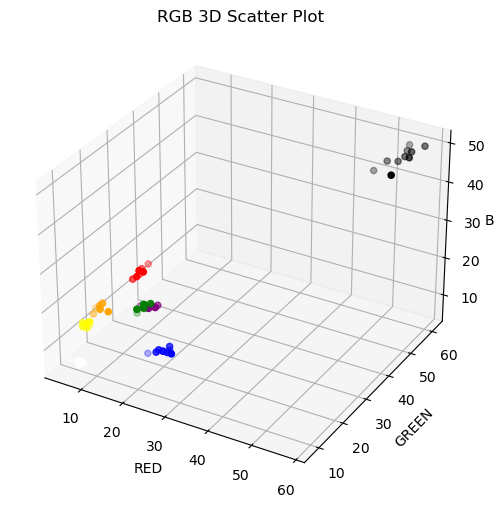

In [16]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

# Координаты для осей (RGB компоненты).
X_r = data[['RED', ' COLOR']]
Y_g = data[[' GREEN', ' COLOR']]
Z_b = data[[' BLUE', ' COLOR']]

# Создать фигуру и 3D-ось.
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Создать диаграмму рассеяния.
ax.scatter(X_r[X_r[' COLOR']==' Orange']['RED'], Y_g[Y_g[' COLOR']==' Orange'][' GREEN'], Z_b[Z_b[' COLOR']==' Orange'][' BLUE'], color='orange')
ax.scatter(X_r[X_r[' COLOR']==' Yellow']['RED'], Y_g[Y_g[' COLOR']==' Yellow'][' GREEN'], Z_b[Z_b[' COLOR']==' Yellow'][' BLUE'], color='yellow')
ax.scatter(X_r[X_r[' COLOR']==' Purple']['RED'], Y_g[Y_g[' COLOR']==' Purple'][' GREEN'], Z_b[Z_b[' COLOR']==' Purple'][' BLUE'], color='purple')
ax.scatter(X_r[X_r[' COLOR']==' White']['RED'], Y_g[Y_g[' COLOR']==' White'][' GREEN'], Z_b[Z_b[' COLOR']==' White'][' BLUE'], color='white')
ax.scatter(X_r[X_r[' COLOR']==' Black']['RED'], Y_g[Y_g[' COLOR']==' Black'][' GREEN'], Z_b[Z_b[' COLOR']==' Black'][' BLUE'], color='black')
ax.scatter(X_r[X_r[' COLOR']==' Green']['RED'], Y_g[Y_g[' COLOR']==' Green'][' GREEN'], Z_b[Z_b[' COLOR']==' Green'][' BLUE'], color='green')
ax.scatter(X_r[X_r[' COLOR']==' Blue']['RED'], Y_g[Y_g[' COLOR']==' Blue'][' GREEN'], Z_b[Z_b[' COLOR']==' Blue'][' BLUE'], color='blue')
ax.scatter(X_r[X_r[' COLOR']==' Red']['RED'], Y_g[Y_g[' COLOR']==' Red'][' GREEN'], Z_b[Z_b[' COLOR']==' Red'][' BLUE'], color='red')

# Метки.
ax.set_xlabel('RED')
ax.set_ylabel('GREEN')
ax.set_zlabel('BLUE')
ax.set_title('RGB 3D Scatter Plot')

plt.show()